# 17 - On-the-fly discrete Fourier transform

In this notebook, we show how to computed Fourier modes during the propagation of the wavefield (on-the-fly) using the discrete Fourier transform (DFT). This method is known to be a memory efficient way to compute gradients for seismic inversion as only a few model-size Fourier modes are necessary instead of the full time history.

The method illustrate the forward modeling to implement. the method in the following paper:

- *Compressive least-squares migration with on-the-fly Fourier transforms*, Philipp A. Witte, Mathias Louboutin, Fabio Luporini, Gerard J. Gorman, and Felix J. Herrmann, 2019, Geophysics, 84(5), R655-R672. [DOI](https://doi.org/10.1190/geo2018-0490.1)

In [1]:
from devito import *

from examples.seismic import demo_model, AcquisitionGeometry, plot_velocity
from examples.seismic.acoustic import AcousticWaveSolver

import matplotlib.pyplot as plt

In [2]:
#NBVAL_IGNORE_OUTPUT
model = demo_model('layers-isotropic', vp=3.0, origin=(0., 0.), shape=(101, 101), spacing=(10., 10.), nbl=40, nlayers=4)

NUMA domain count autodetection failed, assuming 1
Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s


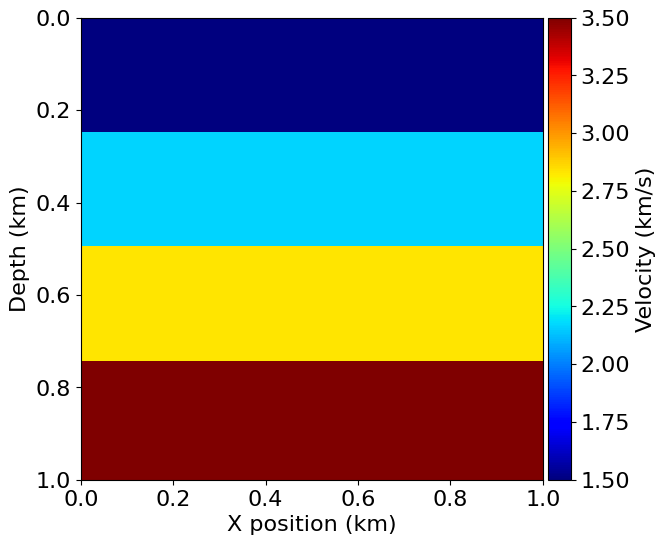

In [3]:
#NBVAL_IGNORE_OUTPUT
plot_velocity(model)

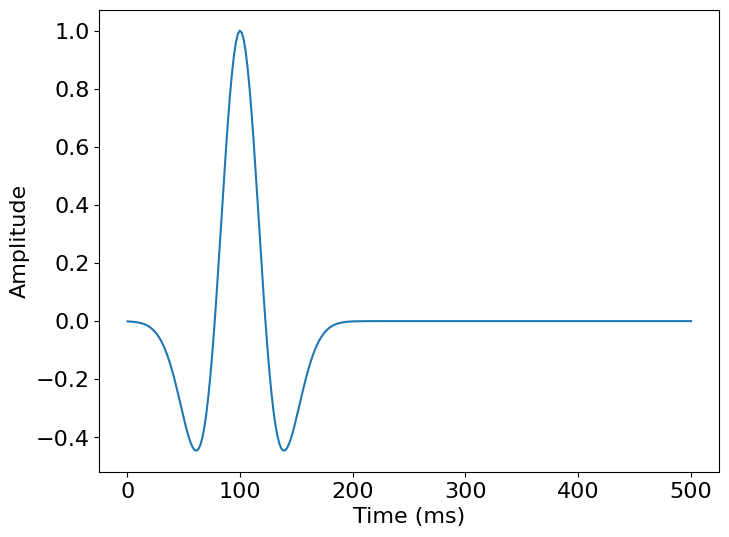

In [4]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
nreceivers = 101
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
t0 = 0.
tn = 500.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

In [5]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt


# Stencil update
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [6]:
freq_mode = Function(name='freq_modes', grid=model.grid, space_order=0, dtype=np.complex64)
freq = .01  # Compute 10Hz slice
omega = 2 * np.pi * freq

basis = exp(1j * omega * model.grid.time_dim * model.grid.time_dim.spacing)
dft = [Inc(freq_mode, basis * u)]

In [7]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src = geometry.src
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec = geometry.rec
rec_term = rec.interpolate(expr=u.forward)

In [8]:
op = Operator([stencil] + src_term + rec_term + dft, subs=model.spacing_map)

In [9]:
#NBVAL_IGNORE_OUTPUT
op(dt=model.critical_dt)

Operator `Kernel` ran in 0.03 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.01551399999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0023819999999999913, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.002333999999999994, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

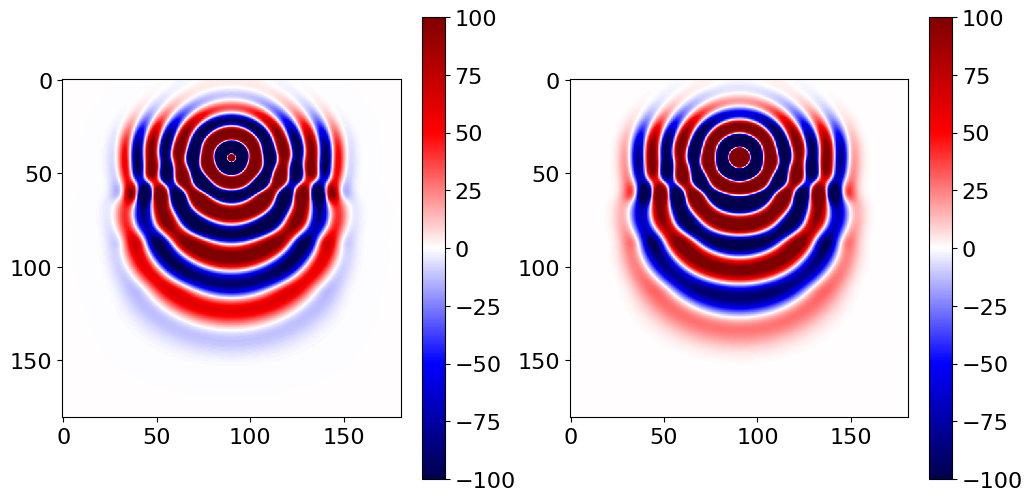

In [10]:
#NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.real(freq_mode.data.T), cmap='seismic', vmin=-1e2, vmax=1e2)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.imag(freq_mode.data.T), cmap='seismic', vmin=-1e2, vmax=1e2)
plt.colorbar()
plt.show()

In [11]:
assert np.isclose(norm(freq_mode), 13873.049, atol=0, rtol=1e-4)
assert np.isclose(norm(u), 323.74207, atol=0, rtol=1e-4)